<a href="https://colab.research.google.com/github/DanieleFoscarin/HDA2021/blob/main/time_Domain_ESC50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLossesKeras

In [ ]:
! pip install optuna --quiet
import optuna

In [2]:
! pip install icecream --quiet
from icecream import ic

In [3]:
! pip install samplerate --quiet
import samplerate

     |████████████████████████████████| 4.0MB 20.4MB/s 


In [4]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
import librosa.display
from tqdm import tqdm, tqdm_notebook, notebook
import gc
import time 
import sys




import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence, SequenceEnqueuer   # try enquerer that uses parallelism
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

#import model 
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

np.random.seed(42)

# Get Dataset

In [6]:
# Clone the entire repo.
!git clone https://github.com/karolpiczak/ESC-50.git


Cloning into 'ESC-50'...
remote: Enumerating objects: 4154, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4154 (delta 10), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4154/4154), 878.78 MiB | 32.97 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Checking out files: 100% (2011/2011), done.


In [7]:
#it is not necessary to read all the audio at the beginning
# TODO implement loading based on the dataframe filenames

ROOT = '/content/ESC-50/audio/'

audio_list = []
for audio in tqdm(sorted(Path(ROOT).iterdir())):
    try:
        # this_sound, sr = librosa.core.load(audio, sr=16000) #NB resampling to 16k
        sr, this_sound = wavfile.read(audio)
     #put in [-1,+1]
    except:
        print('cannot read ', str(audio))

    # downsampling is much faster with this library
    # this_sound = samplerate.resample(this_sound, 16000/44100, converter_type='sinc_fastest')
    audio_list.append(this_sound/32768)
    

print(len(audio_list))

print(np.shape(audio))
# audio_arr = np.array(audio_list)
# print(np.max(audio_arr), np.min(audio_arr))
#need normalization? insiede Sequence

ic(len(audio_list[0]))

100%|██████████| 2000/2000 [00:03<00:00, 662.31it/s]
ic| len(audio_list[0]): 220500


2000
()


220500

In [ ]:
print(sr)
print(sys.getsizeof(audio_list))
print(np.shape(audio_list[0]))

44100
16568
(220500,)


Object `audio_l` not found.


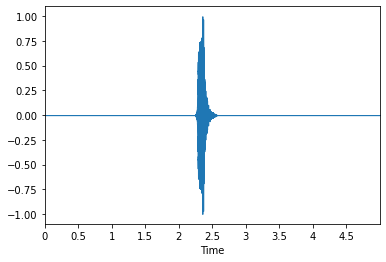

In [56]:
librosa.display.waveplot(audio_list[0], sr)


In [ ]:
data_info = pd.read_csv("/content/ESC-50/meta/esc50.csv")
category_dict = dict(zip(data_info['target'], data_info['category']))
# print(category_dict)
data_info

{0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm', 30: 'door_wood_knock', 34: 'can_opening', 9: 'crow', 22: 'clapping', 48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click', 17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops', 46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind', 25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn', 12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping', 10: 'rain', 7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing', 20: 'crying_baby', 49: 'hand_saw', 24: 'coughing', 39: 'glass_breaking', 28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine', 38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren', 5: 'cat', 33: 'door_wood_creaks', 13: 'crickets'}


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


add columns for augmentation and mixup

augmentation = 0 means that it is the original file
mixup = -1 means that there's no mixup in that file

In [9]:
data_info = pd.read_csv("/content/ESC-50/meta/esc50.csv")

#make a category dictionary
category_dict = dict(zip(data_info['target'], data_info['category']))

#remove unused coumn and add other
aug_col = np.zeros((len(data_info),1))
mixup_col = -1 * np.ones((len(data_info),1))
data_info.drop('esc10', axis=1, inplace=True)
data_info.drop('src_file', axis=1, inplace=True)
data_info.drop('take', axis=1, inplace=True)

data_info['augmentation'] = aug_col
data_info['mixup'] = mixup_col

# one hot encoding from category
data_info = pd.get_dummies(data_info, columns=["category"], prefix='', prefix_sep='') 


data_info

,filename,fold,target,augmentation,mixup,airplane,breathing,brushing_teeth,can_opening,car_horn,cat,chainsaw,chirping_birds,church_bells,clapping,clock_alarm,clock_tick,coughing,cow,crackling_fire,crickets,crow,crying_baby,dog,door_wood_creaks,door_wood_knock,drinking_sipping,engine,fireworks,footsteps,frog,glass_breaking,hand_saw,helicopter,hen,insects,keyboard_typing,laughing,mouse_click,pig,pouring_water,rain,rooster,sea_waves,sheep,siren,sneezing,snoring,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
0,1-100032-A-0.wav,1,0,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1-100038-A-14.wav,1,14,0.0,-1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1-100210-A-36.wav,1,36,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1-100210-B-36.wav,1,36,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1-101296-A-19.wav,1,19,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1996,5-263902-A-36.wav,5,36,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1997,5-51149-A-25.wav,5,25,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1998,5-61635-A-8.wav,5,8,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# Preprocessing functions

remeber to apply augmentation and mixup only on the training samples, foldwise

removing silence at the beginning or at the end of the audio clip

ic| len(audio_list[0]): 220500
ic| len(audio_list[0]): 220500
ic| len(a): 220500


220500

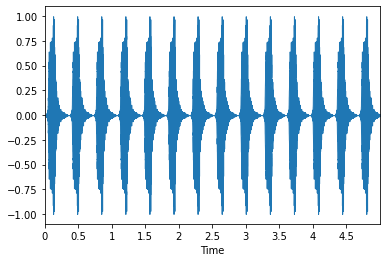

In [40]:
def removeSilence(signal, fill_silence=False):
    
    trimmed = np.trim_zeros(signal)
    if not fill_silence:
        return trimmed
    if fill_silence:
        lt = len(trimmed)
        ls = len(signal)
        # ic(lt,ls)
        if lt < ls:
          trimmed = np.tile(trimmed, int(np.ceil(ls/lt)))
          trimmed = trimmed[:ls]  
        return trimmed

ic(len(audio_list[0]))
a = removeSilence(audio_list[0], fill_silence=True)
librosa.display.waveplot(a, sr=SR)
ic(len(audio_list[0]))
ic(len(a))
# IPython.display.Audio(a, rate=sr)

In [ ]:
def audio_aug(y, sr=44100, low_ps=-3.5, high_ps=3.5, low_ts=0.8, high_ts=1):
    '''It return a signal with random pitch shift ot time strecth '''

    choice = int(np.random.randint(2))
    if choice == 0:
        step = np.random.uniform(low=low_ps, high=high_ps)
        ya = librosa.effects.pitch_shift(y, sr=sr, n_steps=step)
    elif choice == 1:
        rate = np.random.uniform(low=low_ts, high=high_ts)
        ya = librosa.effects.time_stretch(y, rate)
    return ya

def normalize01(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [41]:
# TODO document this
def segmentation(y, seg_len, overlap=0, pad_end='off'):
    y_len = len(y)
    # if seg_len > y_len or overlap > seg_len:        
    seg_begin = 0
    seg_end = seg_begin + seg_len
    seg_list = []
    

    if pad_end == 'full':
        pad = np.zeros((seg_len - overlap,))
        print(np.shape(pad))
        y = np.concatenate((y, pad)) 
        while seg_begin < y_len:
            seg_end = seg_begin + seg_len
            seg_list.append(y[seg_begin:seg_end])
            seg_begin = seg_begin + seg_len - overlap

    if pad_end == 'off':
        while seg_end < y_len:
            seg_end = seg_begin + seg_len
            seg_list.append(y[seg_begin:seg_end])
            seg_begin = seg_begin + seg_len - overlap
    
    if pad_end == 'half':
        pad = np.zeros((int(seg_len/2),))
        print(np.shape(pad))
        y = np.concatenate((y, pad)) 
        while seg_begin + seg_len < len(y):
            seg_end = seg_begin + seg_len
            seg_list.append(y[seg_begin:seg_end])
            seg_begin = seg_begin + seg_len - overlap
    #TODO more options on padding

    return seg_list


out = segmentation(0.5*np.ones((12,)), 5, 0, pad_end='half')
# print(np.shape(out))
print(out)
print(a)


(2,)
[array([0.5, 0.5, 0.5, 0.5, 0.5]), array([0.5, 0.5, 0.5, 0.5, 0.5])]
[-3.05175781e-05  0.00000000e+00  0.00000000e+00 ...  1.31225586e-03
  1.31225586e-03  1.34277344e-03]


remove silence segments from the middle

In [ ]:
if not np.any(np.zeros((20,))):
    print("delete")
print(np.any(np.zeros((20,))))

print(z_count)

delete
False
21


Mixup function
It need one-hot encoding

In [ ]:
# need to understand this

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    # TODO adapt here
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, 0.2, 0.2)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

# Input Pipeline

In [ ]:
#OBSOLETE
class NamesDFDataset:
    def __init__(self, df):
        self.df = df



    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (self.df.iloc[idx, 0], self.df.iloc[idx,2], list(self.df.iloc[idx,5:]))

adata = NamesDFDataset(data_info)
out = adata[0]
print(out[0])
print(out[1])
print(out[2])

1-100032-A-0.wav
0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
! mkdir -p seg_storage
PATH = "/content/seg_storage/"

In [ ]:
#new dataframe that will show the original file for every segment
segment_df = data_info



,filename,fold,target,augmentation,mixup,airplane,breathing,brushing_teeth,can_opening,car_horn,cat,chainsaw,chirping_birds,church_bells,clapping,clock_alarm,clock_tick,coughing,cow,crackling_fire,crickets,crow,crying_baby,dog,door_wood_creaks,door_wood_knock,drinking_sipping,engine,fireworks,footsteps,frog,glass_breaking,hand_saw,helicopter,hen,insects,keyboard_typing,laughing,mouse_click,pig,pouring_water,rain,rooster,sea_waves,sheep,siren,sneezing,snoring,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind


In [ ]:
# a = 0
for i in range(len(data_info)):
    print(data_info.iloc[i,0])
    break
    # print(ROOT+file['filename'])
#     a+=1

# print(a)
# print(i)

1-100032-A-0.wav


In [ ]:
print(20480/44100)
print(sr)

0.46439909297052157
44100


In [ ]:
#TODO move constants at the beginning
a = 0
SR = 44100
SEG_LEN = int(SR*1.28)
OL = int(SEG_LEN/2)

def preprocessing(file_df, file_path, seg_path, augmentation=0, mixup=0):
    
    # initialize segments dataframe
    seg_df = pd.DataFrame(columns=['seg_filename']+list(data_info.columns))

    for i in tqdm(range(len(file_df))):
        #load the file from directory
        this_filename = file_df.iloc[i,0]
        sr, this_sound = wavfile.read(file_path+'/'+this_filename)

        #normalize in [-1,+1] signal range
        this_sound = this_sound/32768

        #remove leading/trailing zeros
        this_sound = removeSilence(this_sound)

        #perform segmentation
        seg_list = segmentation(this_sound, SEG_LEN, OL, pad_end='full')

        #remove eventual silent segments
        for k in range(len(seg_list)):
            if not np.any(seg_list[k]):
                del seg_list[k]
        if i ==4:
            break

        #augmentation TODO
        if augmentation > 0:

        # mix up TODO
        if mixup > 0:
        
        # update segments dataframe and save TODO
        if augmentation == 0 and mixup == 0 :

        

    
    return seg_list, this_sound

print(SEG_LEN)
seg_list, this_sound = preprocessing(data_info, ROOT, PATH)
print(np.shape(seg_list[0]))
IPython.display.Audio(seg_list[2], rate=sr)
IPython.display.Audio(this_sound, rate=sr)

  0%|          | 0/2000 [00:00<?, ?it/s]

56448
(28224,)
(28224,)
(28224,)
(28224,)
(28224,)
(56448,)


In [ ]:
IPython.display.Audio(seg_list[-1], rate=sr)

In [ ]:
seg_df = pd.DataFrame(columns=['seg_filename']+list(data_info.columns))
# ic(list(data_info.columns))
# ic(type(data_info.columns))

seg_df

,seg_filename,filename,fold,target,augmentation,mixup,airplane,breathing,brushing_teeth,can_opening,car_horn,cat,chainsaw,chirping_birds,church_bells,clapping,clock_alarm,clock_tick,coughing,cow,crackling_fire,crickets,crow,crying_baby,dog,door_wood_creaks,door_wood_knock,drinking_sipping,engine,fireworks,footsteps,frog,glass_breaking,hand_saw,helicopter,hen,insects,keyboard_typing,laughing,mouse_click,pig,pouring_water,rain,rooster,sea_waves,sheep,siren,sneezing,snoring,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind


# Online preprocessing and data augmentation

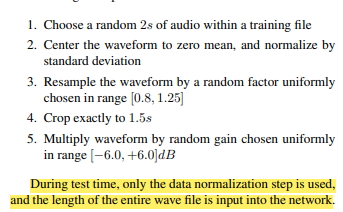

In [30]:
ic(20*np.log10(2))
ic(10**(6/20))

ic| 20*np.log10(2): 6.020599913279624
ic| 10**(6/20): 1.9952623149688795


1.9952623149688795

In [36]:
SR = 44100
SEG1_LEN = 2 * SR
SEG2_LEN = int(1.5 * SR)
ic(SEG1_LEN)

# TODO add mixup in training mode

def onlinePreprocessing(this_filename, file_path,  mode='train'):
    #load the file from directory
    _, this_sound = wavfile.read(file_path+'/'+this_filename)
    # TODO downsampling

    if mode == 'train':
        # remove silence
        this_sound = removeSilence(this_sound, fill_silence=True)

        #pick a segment 
        start_idx = np.random.randint(0, len(this_sound)-SEG1_LEN)
        seg = this_sound[start_idx:start_idx+SEG1_LEN]

        #random resampling
        resample_factor = np.random.uniform(0.8, 1.25)
        seg = samplerate.resample(seg, resample_factor, converter_type='sinc_fastest')

        #crop to fixed length
        seg = seg[:SEG2_LEN]

        #standardization
        seg = (seg - np.mean(seg))/np.std(seg)

        #random gain change [-6,+6]dB
        gain_dB = np.random.uniform(-6,6)
        gain = 10**(gain_dB/20)
        seg = gain*seg


    if mode == 'test':
        # remove silence
        seg = removeSilence(this_sound, fill_silence=false)
        
        #standardization
        seg = (seg - np.mean(seg))/np.std(seg)

    
    return seg





ic| SEG1_LEN: 88200


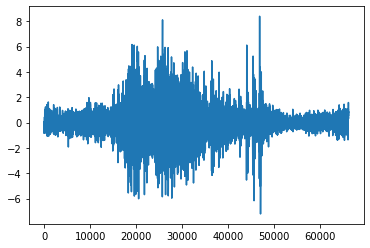

In [55]:
#check preprocessor 
seg = onlinePreprocessing(data_info.iloc[100,0], ROOT, mode='train')
plt.plot(seg)
Audio(seg, rate=SR)

## Dataloader

In [38]:
# TODO test mode!!
class AudioSequence(Sequence):
    
    def __init__(self, file_df, file_path, batch_size, mode):
        self.file_df = file_df
        self.file_path = file_path
        self.batch_size = batch_size
        self.mode = mode



    def __len__(self):
        return len(self.file_df)


    def __getitem__(self, idx):
        

        batch_names = self.file_df.iloc[idx*self.batch_size:(idx + 1)*self.batch_size,0].to_numpy()
        batch_seg = np.zeros((SEG2_LEN, self.batch_size))
        for i in range(self.batch_size):
            batch_seg[:,i] = onlinePreprocessing(batch_names[i], self.file_path, mode='train')

        # batch target need to change when using mixup
        batch_target = self.file_df.iloc[idx*self.batch_size:(idx + 1)*self.batch_size, 5:].to_numpy()  #using onehot target
        return batch_seg, batch_target



In [53]:
dum_loader = AudioSequence(data_info, ROOT, 6, 'train')
x,y = dum_loader[9]

ic(np.shape(x))

ic| np.shape(x): (66150, 6)


(66150, 6)

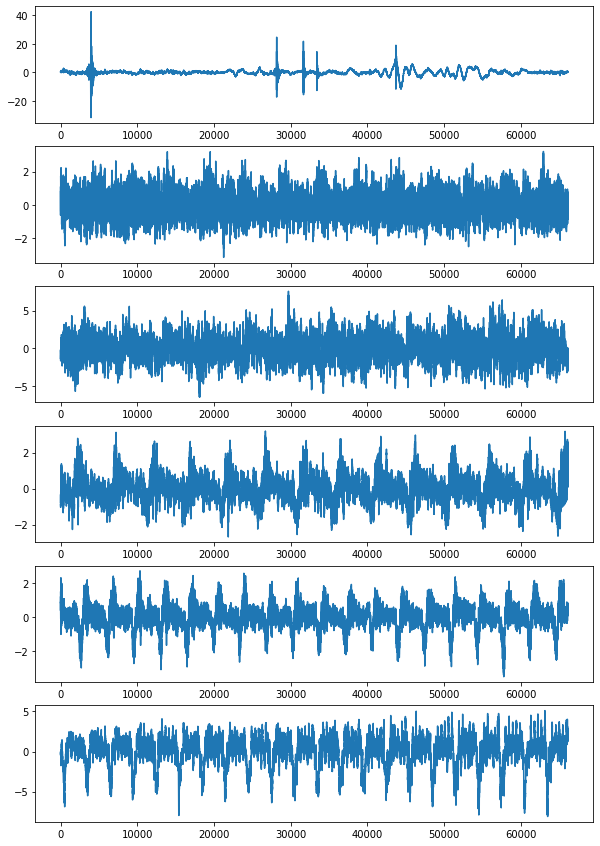

In [55]:
fig, ax = plt.subplots(6,1, figsize=(10,15))
npimg = np.zeros((4,3,60,431))

for i in range(6):
    ax[i].plot(x[:,i])
